In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.utilities._toolbox as sf
import utils.common_data_needs as cdn
import warnings
warnings.filterwarnings("ignore")

from typing import *

plt.style.use("dark_background", )



Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   4068.6 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [150]:
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")



# SET SOME GLOBALS

# fields
_FIELD_SSP_ENTC = matt.get_subsector_attribute("Energy Technology", "pycategory_primary_element")
_FIELD_PURCHASES_TOTAL = "total_purchases_kwh"
_FIELD_QUARTER = "Quarter"
_FIELD_SALES_TOTAL = "total_sales_kwh"
_FIELD_YEAR = "Year"

# flags
_FLAG_DROP = "_DROP"

# sheets in the table
_SHEET_PURCHASES = "Energy_Purchased_kWh"
_SHEET_SALES = "Energy Sales_kWh"

# units associated with input data
_UNITS_DATASET_ERA = "kwh"

# year to build estimates out to
_YEAR_TARGET = 2100

# Load data we'll work with

- `20250327_STA_Distribution_Statistics_Q4_2024.xlsm` is sourced from the [Uganda Electricity Regulatory Authority](https://www.era.go.ug/energy-purchases-sales-and-losses/)
- The following screenshot was taken on July 9, 2025 at 5:22 PM CDMX time from the website link above. It shows estimates of loss by year. These were used to validate the calculations below, where total sales are divided by total purchases to estimate the total flow through, and loss is 1 - flow. 

![screenshot_distribution_losses_20250709.png](./input_data/era/screenshot_distribution_losses_20250709.png)

In [157]:
##  FUNCTIONS

def get_era_distribution_raw(
    path: pathlib.Path,
) -> pd.DataFrame:
    """Retrieve the purchases by distributers and sales by distributers. At
        https://www.era.go.ug/energy-purchases-sales-and-losses/, ERA defines
        Energy Losses 
            "as the difference between the energy purchased and sales. The 
            energy distribution losses reduced from 17.7% in 2022 to 17.3% in 2023. losses as 
    """


    ##  GET THE RAW EXCEL
    dict_dfs = pd.read_excel(
        path, 
        sheet_name = [_SHEET_PURCHASES, _SHEET_SALES], 
        skiprows = 2,
        #nrows = 
    )

    dict_dfs = dict(
        (
            k, 
            (
                v
                .drop(columns = "Unnamed: 0")
                .dropna(
                    how = "any",
                    subset = [_FIELD_YEAR, _FIELD_QUARTER],
                )
                .replace("-", 0.0)
                .replace(" ", 0.0)
                .fillna(0.0)
            )
        ) for k, v in dict_dfs.items()
    )
    
    return dict_dfs



def get_loss_estimate(
    dict_era_raw: Dict[str, pd.DataFrame],
    modvar_tlf: 'ModelVariable',
    max_lookback_project: int = 10,
    min_loss: float = 0.02,
) -> pd.DataFrame:
    """Get estimates of transmission loss by year.

    Keyword Arguments
    -----------------
    max_lookback_project : int
        Maximum lookback applied to retroactive regressions for trend lines
    min_loss : float
        Minimum allowable loss
    """

    warnings.warn(
        f"""Verify manually that units in both sheets are equivalent. 
        When run last, units for purchases and sales were both: {_UNITS_DATASET_ERA}
        """
    )

    # get data frames
    df_purchases = dict_era_raw.get(_SHEET_PURCHASES).copy()
    df_sales = dict_era_raw.get(_SHEET_SALES).copy()

    global fields_sales_sum
    # set some fields 
    fields_index = [_FIELD_QUARTER, _FIELD_YEAR]
    fields_purchase_sum = [x for x in df_purchases.columns if x not in fields_index]
    fields_sales_sum = [x for x in df_sales.columns if x not in fields_index]

    
    # set totals
    df_purchases[_FIELD_PURCHASES_TOTAL] = (
        df_purchases[fields_purchase_sum]
        .fillna(0.0)
        .sum(axis = 1)
    )

    df_sales[_FIELD_SALES_TOTAL] = (
        df_sales[fields_sales_sum]
        .fillna(0.0)
        .sum(axis = 1)
    )


    ##  CALCULATE LOSS

    df_loss = pd.merge(
        df_purchases[fields_index + [_FIELD_PURCHASES_TOTAL]],
        df_sales[fields_index + [_FIELD_SALES_TOTAL]],
        how = "inner"
    )

    vec_total_purchases = df_loss[_FIELD_PURCHASES_TOTAL]
    vec_total_sales = df_loss[_FIELD_SALES_TOTAL]
    
    # calculate loss
    df_loss[modvar_tlf.fields[0]] = sf.vec_bounds(
        1 - np.nan_to_num(
            vec_total_sales/vec_total_purchases,
            nan = 0.0,
            posinf = 0.0,
        ),
        (0.0, 1.0)
    )

    # aggregate
    df_loss = (
        df_loss
        .get([_FIELD_YEAR, modvar_tlf.fields[0]])
        .groupby(_FIELD_YEAR)
        .mean()
        .reset_index()
        .rename(columns = {_FIELD_YEAR: time_periods.field_year, })
    )



    ##  PROJECT

    arr = df_loss[[modvar_tlf.fields[0]]].to_numpy().copy()
    year_0 = df_loss[time_periods.field_year].max()
    n_proj = _YEAR_TARGET - year_0

    # lists that will be updated
    years = []
    vec_new = []

    # iteratively apply a constrained lookback regression
    for i in range(n_proj):
        val_new = sf.project_from_array(
            arr,
            max_lookback = max_lookback_project,
        )
    
        val_new[0] = max(val_new[0], min_loss)
        arr = np.concatenate([arr, np.array([val_new])])

        
        vec_new.append(val_new[0])
        years.append(year_0 + i + 1)

    # projection df
    df_proj = pd.DataFrame(
        {
            time_periods.field_year: years,
            modvar_tlf.fields[0]: vec_new,
        }
    )

    out = (df_loss, df_proj, )
    
    return out


    


    
# get some SISEPUEDE elements
attr_entc = matt.get_attribute_table("Energy Technology")
modvar_tlf = matt.get_variable(
    models.model_enerprod.modvar_enfu_transmission_loss_frac_electricity,
)


# base dataset
df_uganda = cdn.get_raw_ssp_inputs()
dict_era_raw = get_era_distribution_raw(
    cdn._PATH_INPUTS.joinpath("era", "20250327_STA_Distribution_Statistics_Q4_2024.xlsm")
)


# build 
df_loss, df_proj = get_loss_estimate(
    dict_era_raw, 
    modvar_tlf
)


<Axes: xlabel='year', ylabel='Fraction of electricity lost in transmission and distribution'>

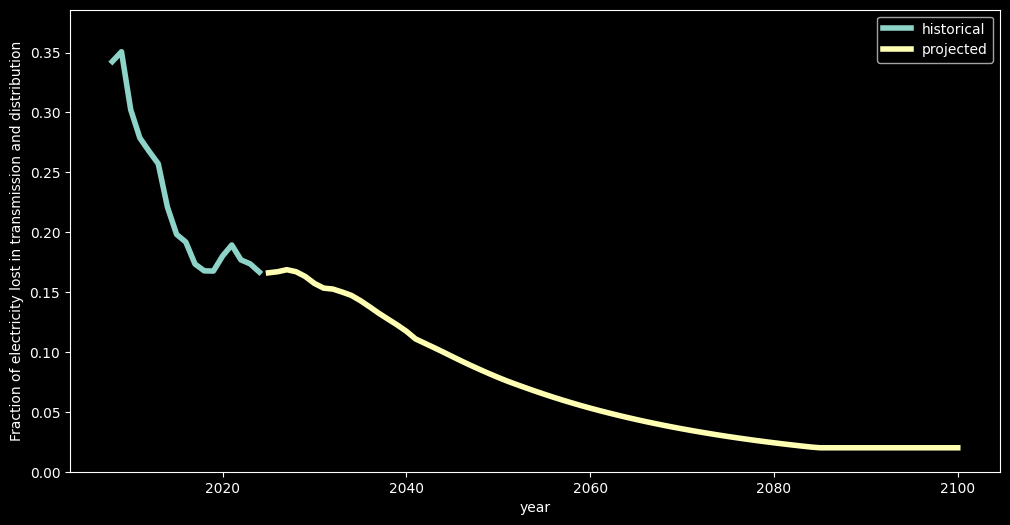

In [163]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_ylabel("Fraction of electricity lost in transmission and distribution")
ax.set_ylim(0, df_est[modvar_tlf.fields[0]].max()*1.1)

(
    df_loss
    .rename(
        columns = {modvar_tlf.fields[0]: "historical", },
    )
    .plot(
        x = time_periods.field_year, 
        ax = ax, 
        linewidth = 4, 
    )
)

(
    df_proj
    .rename(
        columns = {modvar_tlf.fields[0]: "projected", },
    )
    .plot(
        x = time_periods.field_year, 
        ax = ax, 
        linewidth = 4, 
    )
)



# Write Output

In [165]:
df_transmission_loss = (
    pd.concat(
        [df_loss, df_proj],
        axis = 0,
    )
    .sort_values(by = [time_periods.field_year], )
    .reset_index(drop = True, )
)

df_transmission_loss.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_tlf.name_fs_safe.upper()}.csv"),
    encoding = "UTF-8",
    index = None,
)